## _Primera parte._ Procesamiento de datos y calibración de clasificadores.

In [148]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
%matplotlib inline
mpl.rcParams['figure.figsize'] = (21, 10)

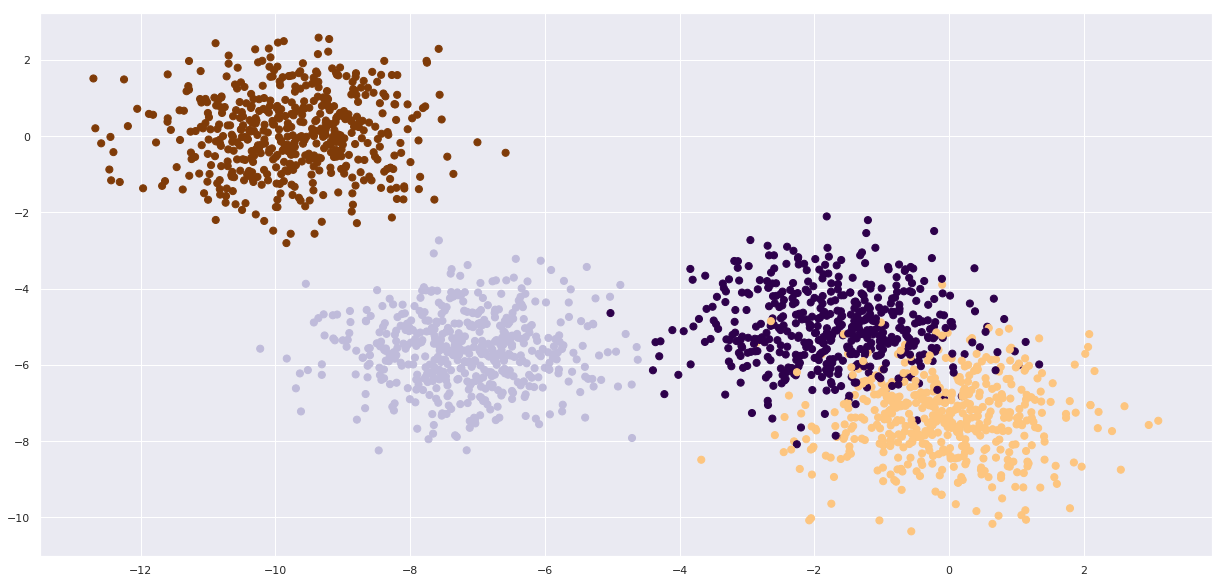

In [149]:
from sklearn.datasets import make_blobs
# Crear clases de prueba
X_blob, y_blob = make_blobs(2000, n_features=2, centers=4, random_state=9)

# Graficar el conjunto de datos encontrado
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, s=50, cmap='PuOr')

In [150]:
# Implementación propia para ajustar los datos a mis propias implementaciones
def data_proc(x, y, n_caract, n_clas):
    arreglados = sorted(zip(y, x), key=lambda pair: pair[0])
    dicc_datos = dict()
    for i in range(n_clas):
        dicc_datos[i] = np.array([])

    for l, k in dicc_datos.items():
        lista_vals = list()
        for m in range(n_caract):
            list_arr_1 = np.array([])
            for i, j in arreglados:
                if i == l:
                    list_arr_1 = np.append(list_arr_1, j[m])
            lista_vals.append(list_arr_1)

            dicc_datos[l] = np.stack(lista_vals, axis=0)
            
    return dicc_datos

In [151]:
from sklearn.model_selection import train_test_split

# Separar el conjunto de datos para hacer unos de entrenamiento y otros de prueba
x_entre, x_prueba, y_entre, y_prueba = train_test_split(X_blob, y_blob, test_size=0.3, random_state=5, shuffle=False)

### _Euclidiano_ (mínima distancia)

In [152]:
# Clasificador euclidiano
# Se define la nueva función decisión para cualquier número de clases
def euclidiano(entrena, pred):
    dicc_vals = dict()
    
    for k, v in entrena.items():
        # Encontrar la media de cada clase
        class_mean = np.mean(v, axis=1)
        # Por cada clase, encontrar la norma de la media, al cuadrado
        mean_sq = np.power(np.linalg.norm(class_mean), 2.0)
        # Calcular la función de decisión
        g_dec = np.dot(pred, class_mean) - 0.5*mean_sq
        # Asignar este valor a la clase
        dicc_vals[k] = g_dec
        
    # Devolver aquella clase que contenga la máxima función de decisión
    return max(dicc_vals, key=dicc_vals.get)

In [153]:
from sklearn.metrics import classification_report

# Probar con los datos de prueba
sint_dict = data_proc(x_entre, y_entre, 2, 4)
lista_prueba = np.array([])
for i in x_prueba:
    lista_prueba = np.append(lista_prueba, euclidiano(sint_dict, i))

# Crear el reporte de clasificación
print(classification_report(y_prueba, lista_prueba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       0.95      0.92      0.94       149
           2       1.00      1.00      1.00       150
           3       0.92      0.95      0.94       145

   micro avg       0.97      0.97      0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



### _k-Nearest Neighbors_

In [154]:
from scipy.spatial import cKDTree

class k_nearest_n:
    def __init__(self, entrena, etiq, k_n):
        self.kd_tree = cKDTree(entrena)
        self.prob_dicc = dict()
        self.kn = k_n
        self.labels = etiq
        
    def _dicc_init(self):
        for i in range(len(np.unique(self.labels))):
            self.prob_dicc[i] = 0.0
    
    def predecir(self, pred):
        self._dicc_init()
        __, indices = self.kd_tree.query(pred, k=self.kn)
    
        for k in self.prob_dicc.keys():
            prob = 0.0
            for i, j in enumerate(self.labels):
                for l in indices:
                    if i == l:
                        if j == k:
                            self.prob_dicc[k] += 1

        for i, j in self.prob_dicc.items():
            self.prob_dicc[i] = j / self.kn

    #     print(prob_dicc)
        return max(self.prob_dicc, key=self.prob_dicc.get)

In [155]:
# Crear el reporte de clasificación
lista_prueba = np.array([])
knn_imp = k_nearest_n(x_entre, y_entre, 5)
for i in x_prueba:
    lista_prueba = np.append(lista_prueba, knn_imp.predecir(i))

print(classification_report(y_prueba, lista_prueba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       0.92      0.92      0.92       149
           2       1.00      0.99      1.00       150
           3       0.91      0.92      0.91       145

   micro avg       0.96      0.96      0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



### _Gaussian Naive Bayes_

In [156]:
def gaussian_nb(entrena, pred):
    h_disc = dict()
    total_puntos = sum([i.shape[1] for i in entrena.values()])
    
    # Una constante útil
    log_2pi = np.log(2.0*np.pi)
    
    for i, j in entrena.items():
        # Calcular la distancia a la media
        delta = pred - np.mean(j, axis=1)
        # Encontrar la matriz de covarianza
        matr_cov = np.cov(j)
        # Y su inversa
        inv_cov_matr = np.linalg.pinv(matr_cov)
        # Distancia de Mahalanobis
        m_dist = -0.5 * np.dot(np.dot(delta, inv_cov_matr), delta)
        # Restar el siguiente término, depende de la dimensión del arreglo
        m_dist += -0.5 * j.shape[0] * log_2pi
        # Calcular el determinante de la matriz de covarianza, restarlo
        # de la distancia acumulada
        eig_values, __ = np.linalg.eig(matr_cov)
        pseudo_det = np.product(eig_values[eig_values > 1e-14])
        m_dist += -0.5 * np.log(pseudo_det)
        # Calcular la probabilidad a priori, y sumarla a la distancia
        a_priori = j.shape[1] / total_puntos
        m_dist += np.log(a_priori)
        # Agregar esta probabilidad al diccionario final
        h_disc[i] = m_dist
        
    # Devolver aquella clase que contiene la mayor probabilidad
    return max(h_disc, key=h_disc.get)

In [157]:
# Crear el reporte de clasificación
lista_prueba = np.array([])
for i in x_prueba:
    lista_prueba = np.append(lista_prueba, gaussian_nb(sint_dict, i))

print(classification_report(y_prueba, lista_prueba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       0.95      0.92      0.94       149
           2       1.00      1.00      1.00       150
           3       0.92      0.95      0.94       145

   micro avg       0.97      0.97      0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



## _Segunda parte._ Clasificación de FourClass

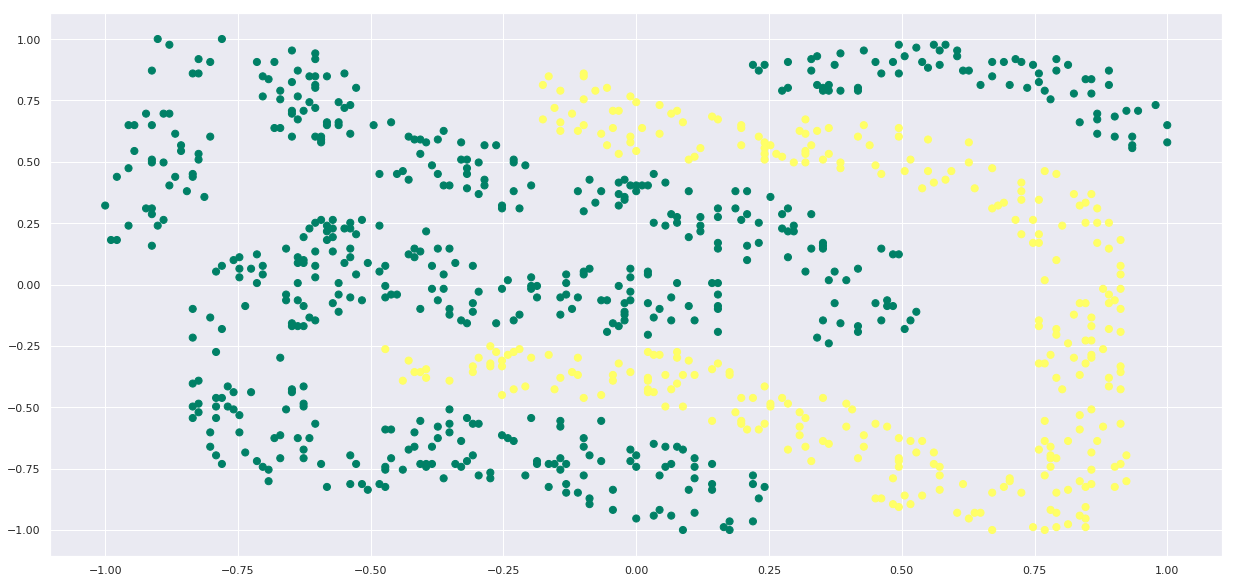

In [158]:
import os
# Añadir los datos de las clases
fc_x, fc_y, fc_etiq = np.loadtxt(os.path.abspath('../fourclass.csv'), delimiter=',', skiprows=1, unpack=True)
# Graficar los datos
plt.scatter(fc_x, fc_y, c=fc_etiq, s=50, cmap='summer')

In [159]:
# Sustituir el nombre de la clase para evitar ciertos errores
fc_etiq[fc_etiq == -1] = 0
# Separar los datos para predicción y entrenamiento
x_entre, x_prueba, y_entre, y_prueba = train_test_split(np.stack((fc_x, fc_y), axis=-1), fc_etiq, test_size=0.3, random_state=7, shuffle=False)

## _Euclidiano_

In [160]:
sint_dict = data_proc(x_entre, y_entre, 2, 2)
lista_prueba = np.array([])
for i in x_prueba:
    lista_prueba = np.append(lista_prueba, euclidiano(sint_dict, i))

# Crear el reporte de clasificación
print(classification_report(y_prueba, lista_prueba, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       156
           1       0.65      0.62      0.63       103

   micro avg       0.71      0.71      0.71       259
   macro avg       0.70      0.70      0.70       259
weighted avg       0.71      0.71      0.71       259



## k-Nearest Neighbors

In [161]:
knn_imp = k_nearest_n(x_entre, y_entre, 5)
lista_prueba = np.array([])
for i in x_prueba:
    lista_prueba = np.append(lista_prueba, knn_imp.predecir(i))

# Crear el reporte de clasificación
print(classification_report(y_prueba, lista_prueba, labels=[0, 1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       1.00      1.00      1.00       103

   micro avg       1.00      1.00      1.00       259
   macro avg       1.00      1.00      1.00       259
weighted avg       1.00      1.00      1.00       259



## Gaussian Naive Bayes

In [162]:
sint_dict = data_proc(x_entre, y_entre, 2, 2)
lista_prueba = np.array([])
for i in x_prueba:
    lista_prueba = np.append(lista_prueba, gaussian_nb(sint_dict, i))

# Crear el reporte de clasificación
print(classification_report(y_prueba, lista_prueba, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       156
           1       0.89      0.54      0.67       103

   micro avg       0.79      0.79      0.79       259
   macro avg       0.82      0.75      0.76       259
weighted avg       0.81      0.79      0.78       259

